<br>
<h1 style = "font-size:30px; font-weight : bold; color : blue; text-align: center; border-radius: 10px 15px;">Chest X-Ray (Pneumonia): Image Classification w/Convolutional Neural Networks and Transfer Learning</h1>

---

# Overview

The goal of this notebook is to use Convolutional Neural Networks on Chest X-Ray images to determine which samples are from patients with Pneumonia. In this dataset (version 3), there is one folder representing the train set and another one for the test set. The train folder is later split in the notebook into train/validation sets.

I use three different approaches for image classification: 1) A simple CNN, 2) Transfer Learning, using a pretrained model with frozen layers as the base for feature extraction and 3) Fine Tuning, unfreezing the last layers of the pretrained model.

Note: I’m using the third version of the Chest X-Ray dataset [(link)](https://www.kaggle.com/tolgadincer/labeled-chest-xray-images)

# <a id="1">Dataset Information</a>

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# <a id="2">Importing Packages and Dataset</a>

In [ ]:
! pip install kaggle

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale=1./255,
                                   ) # set validation split

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset="training"
    ) # set as training data

test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
   ) # set as validation data

valid_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset="validation")

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

# <a id="3">Exploring the Data</a>

print 3 images from every folder in train_generator, validation, test , every three images in one row


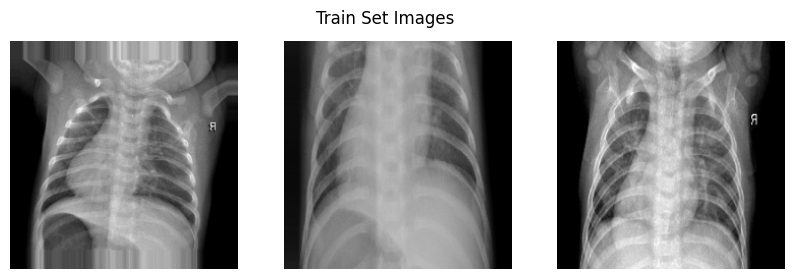

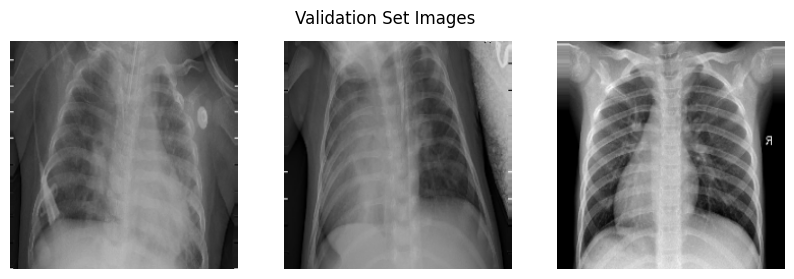

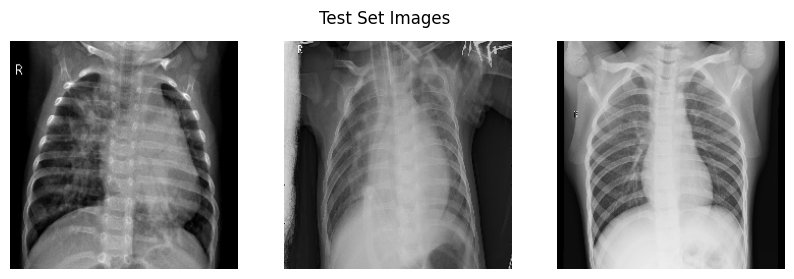

In [ ]:
def plot_images(generator, title):
  x, y = next(generator)
  fig, axes = plt.subplots(1, 3, figsize=(10, 3))
  fig.suptitle(title, fontsize=12)
  for i in range(3):
    axes[i].imshow(x[i])
    axes[i].axis('off')
  plt.show()

plot_images(train_generator, "Train Set Images")
plot_images(valid_generator, "Validation Set Images")
plot_images(test_generator, "Test Set Images")

# <a id="5">Custom CNN</a>

add checkpoint for saving the best model, reduce on plateur, early stoping

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="CNN.weights.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

Convolutional Neural Network (CNN) for Binary Image Classification using Keras

In [ ]:
model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

Model Compilation for Binary Classification

In [ ]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Training the CNN Model with Validation and Callbacks

In [ ]:
history1 = model1.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 787ms/step - accuracy: 0.7912 - loss: 0.4305 - val_accuracy: 0.9158 - val_loss: 0.2019 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 726ms/step - accuracy: 0.9081 - loss: 0.2194 - val_accuracy: 0.9301 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 717ms/step - accuracy: 0.9100 - loss: 0.2184 - val_accuracy: 0.9474 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 731ms/step - accuracy: 0.9275 - loss: 0.1893 - val_accuracy: 0.9388 - val_loss: 0.1745 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 731ms/step - accuracy: 0.9368 - loss: 0.1704 - val_accuracy: 0.9550 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 731ms/step - accuracy: 0.9408 - loss: 0.1549 - val_accuracy: 0.9483 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 741ms/step - accuracy: 

Model Architecture Summary

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

Training vs Validation Loss Over Epochs

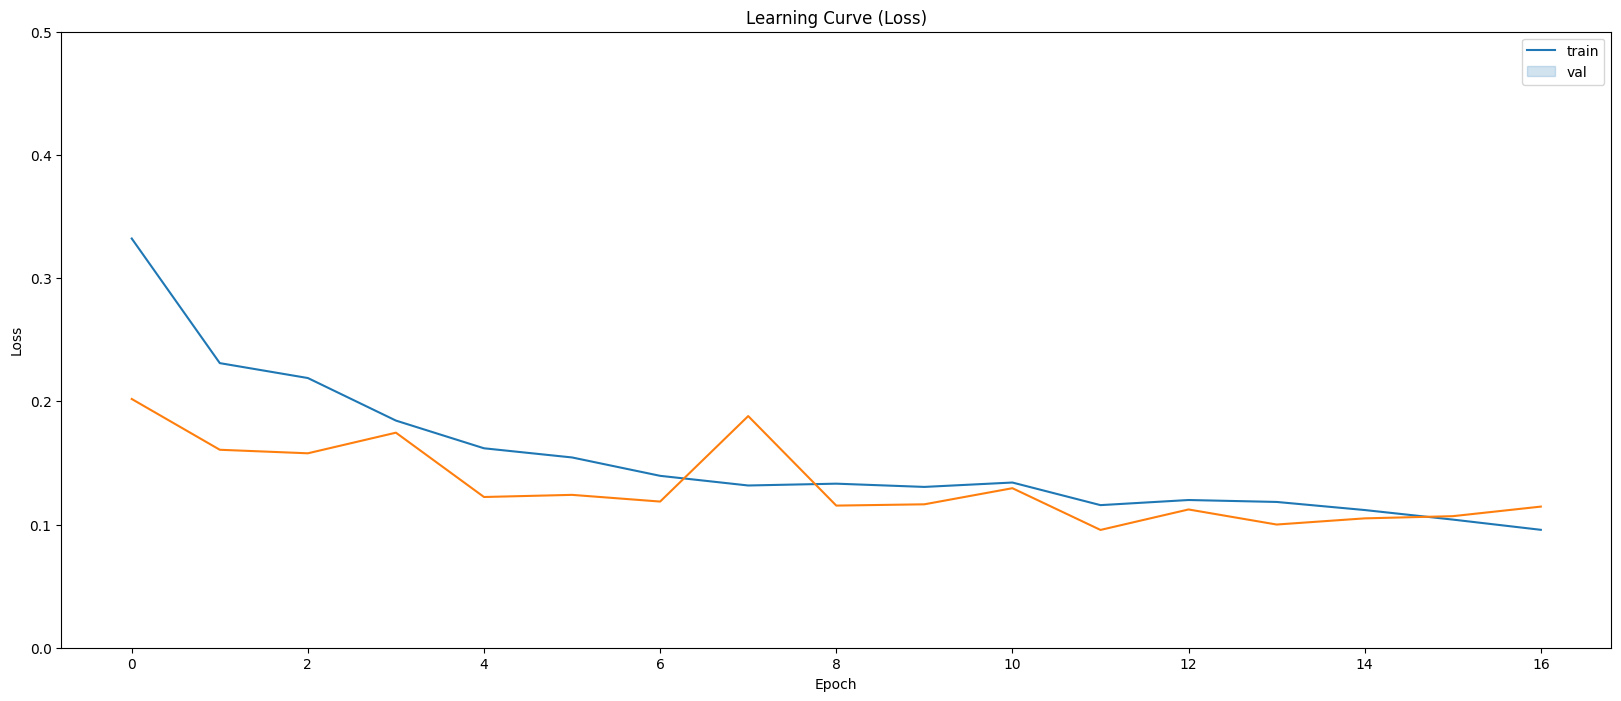

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history1.epoch, y = history1.history['loss'])
sns.lineplot(x = history1.epoch, y = history1.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

Plotting Training and Validation Accuracy Curve

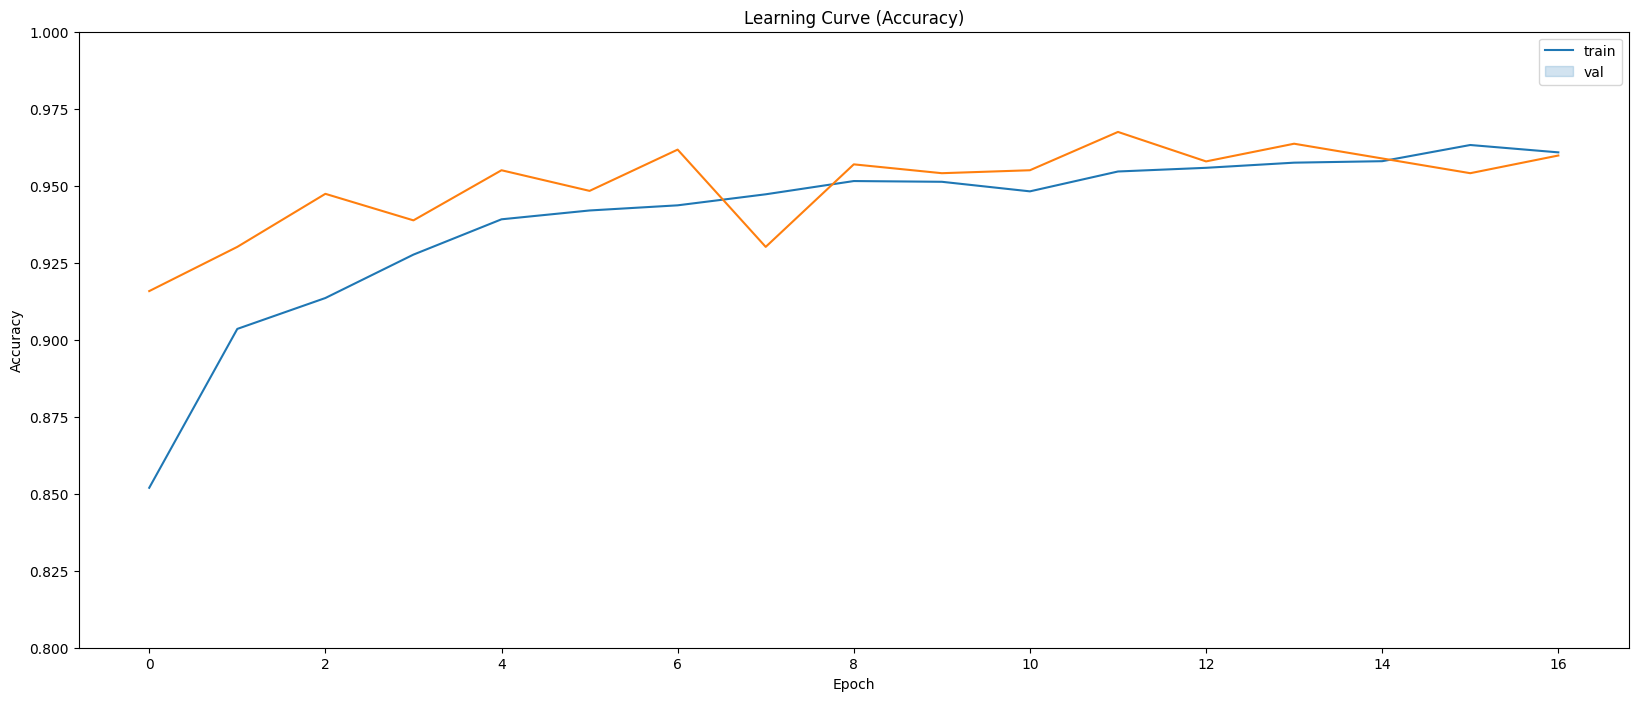

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history1.epoch, y = history1.history['accuracy'])
sns.lineplot(x = history1.epoch, y = history1.history['val_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

Evaluating the Model on Validation Data

In [ ]:
score = model1.evaluate(valid_generator, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1047716736793518
Val accuracy: 0.9550239443778992


Final Evaluation on Test Data

In [ ]:
score = model1.evaluate(test_generator, steps=len(test_generator), verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.16772039234638214
Test accuracy: 0.9439102411270142


Defining a Custom CNN Model with Regularization

In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model2 = keras.Model(inputs=[inputs], outputs=output)

    return model2

Compiling the Custom CNN Model

In [ ]:
model2 = get_model()

model2.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['binary_accuracy']   # ✅ list
)

Summary of the Custom CNN Model Architecture

In [ ]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

Training the Custom CNN with Validation and Callbacks

In [ ]:
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - binary_accuracy: 0.7723 - loss: 0.5819 - val_binary_accuracy: 0.7426 - val_loss: 0.6993 - learning_rate: 3.0000e-05
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 698ms/step - binary_accuracy: 0.8792 - loss: 0.2866 - val_binary_accuracy: 0.7426 - val_loss: 1.1820 - learning_rate: 3.0000e-05
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 700ms/step - binary_accuracy: 0.8832 - loss: 0.2678 - val_binary_accuracy: 0.7426 - val_loss: 1.0426 - learning_rate: 3.0000e-05
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 694ms/step - binary_accuracy: 0.9070 - loss: 0.2312 - val_binary_accuracy: 0.7445 - val_loss: 0.8265 - learning_rate: 3.0000e-05
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 703ms/step - binary_accuracy: 0.9041 - loss: 0.2288 - val_binary_accuracy: 0.7665 - val_loss: 0.6443 - learning_rate: 3.0000e-05
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 693ms/step - binary_accuracy: 0.9113 - loss: 0.2073 - val_binary_accuracy: 0.8995 - val_lo

Plotting Training and Validation Loss Curve

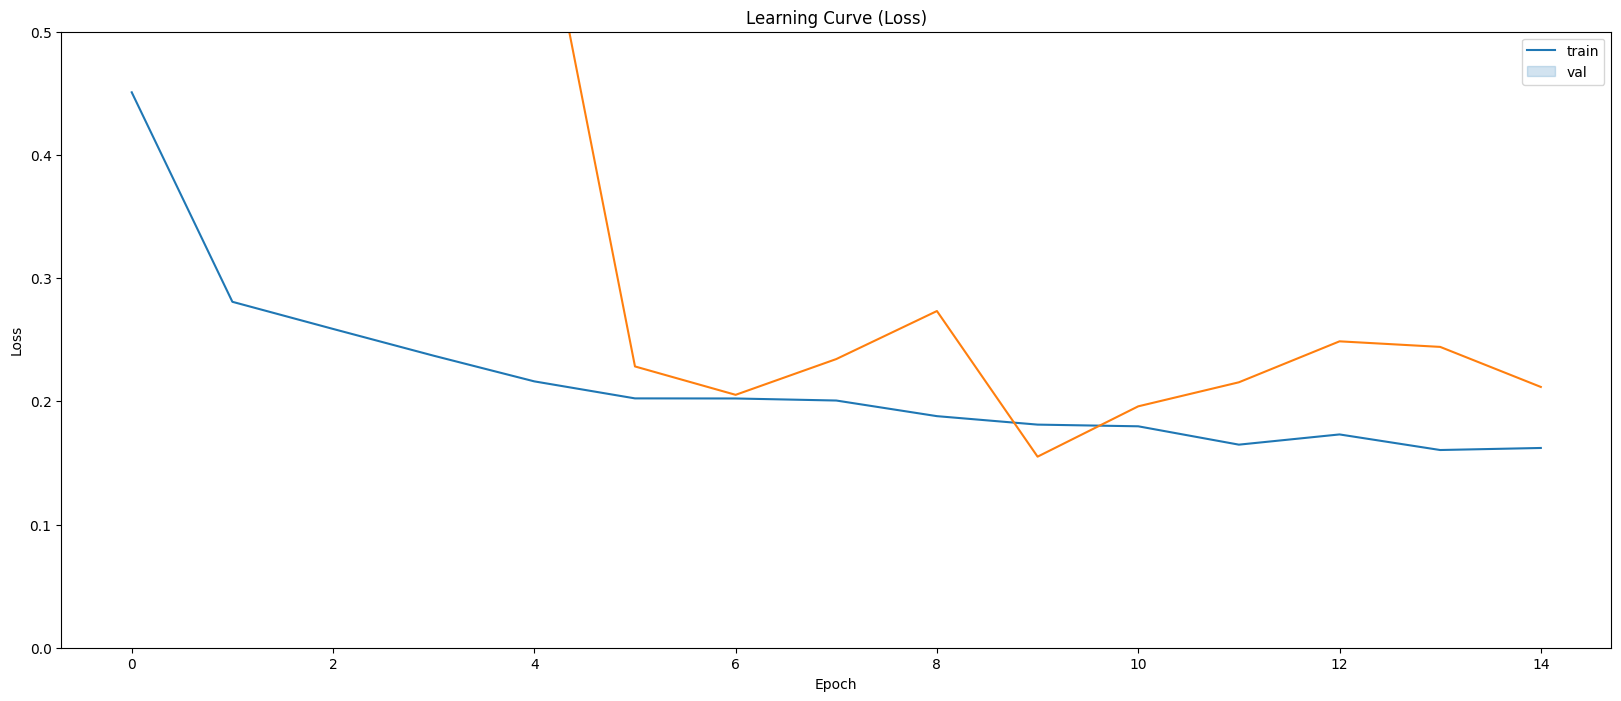

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history2.epoch, y = history2.history['loss'])
sns.lineplot(x = history2.epoch, y = history2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

Plotting Training and Validation Binary Accuracy Curve

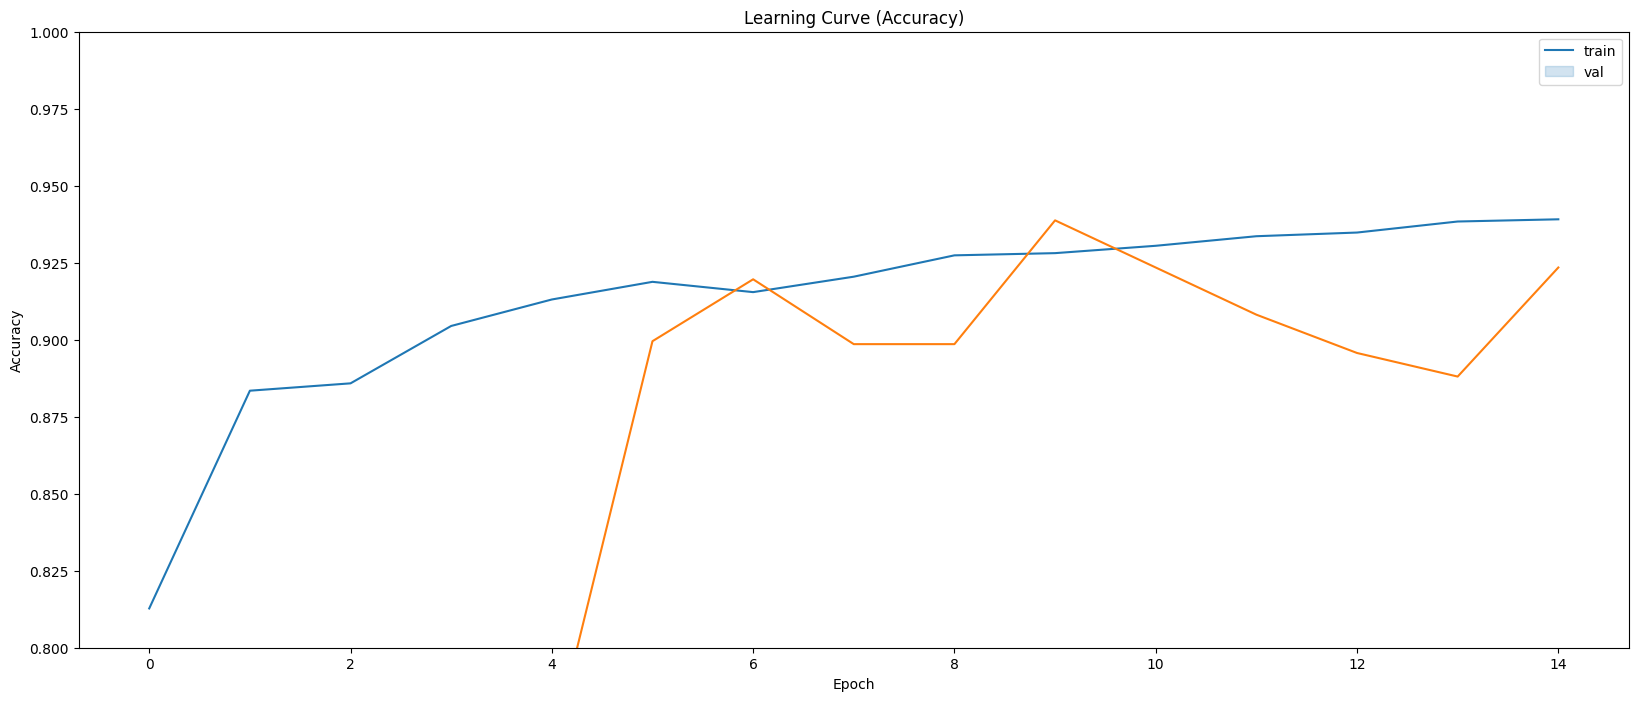

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history2.epoch, y = history2.history['binary_accuracy'])
sns.lineplot(x = history2.epoch, y = history2.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

Evaluating Model Performance on Validation Data

In [ ]:
score = model2.evaluate(valid_generator, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.19714905321598053
Val accuracy: 0.9224880337715149


Final Evaluation of the Model on Test Data

In [ ]:
score = model2.evaluate(test_generator, steps = len(test_generator), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.29950952529907227
Test accuracy: 0.9006410241127014


# <a id="6">Transfer Learning</a>

Building a Transfer Learning Model using ResNet152V2

In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Compiling the Transfer Learning Model (ResNet152V2)

In [ ]:
keras.backend.clear_session()

model_pretrained1 = get_pretrained()
model_pretrained1.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])

Summary of the Pretrained ResNet152V2 Model

In [ ]:
model_pretrained1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

Training the Transfer Learning Model with Validation and Callbacks

In [ ]:
history3 = model_pretrained1.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 158s 997ms/step - binary_accuracy: 0.7471 - loss: 0.5053 - val_binary_accuracy: 0.9081 - val_loss: 0.2409 - learning_rate: 5.0000e-05
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 802ms/step - binary_accuracy: 0.9144 - loss: 0.2415 - val_binary_accuracy: 0.9321 - val_loss: 0.1869 - learning_rate: 5.0000e-05
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 166s 989ms/step - binary_accuracy: 0.9312 - loss: 0.1851 - val_binary_accuracy: 0.9445 - val_loss: 0.1614 - learning_rate: 5.0000e-05
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 828ms/step - binary_accuracy: 0.9348 - loss: 0.1646 - val_binary_accuracy: 0.9445 - val_loss: 0.1506 - learning_rate: 5.0000e-05
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 830ms/step - binary_accuracy: 0.9432 - loss: 0.1611 - val_binary_accuracy: 0.9483 - val_loss: 0.1408 - learning_rate: 5.0000e-05
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 831ms/step - binary_accuracy: 0.9368 - loss: 0.1688 - val_binary_accuracy: 0.9512 - v

Plotting Training and Validation Loss for the Pretrained Model

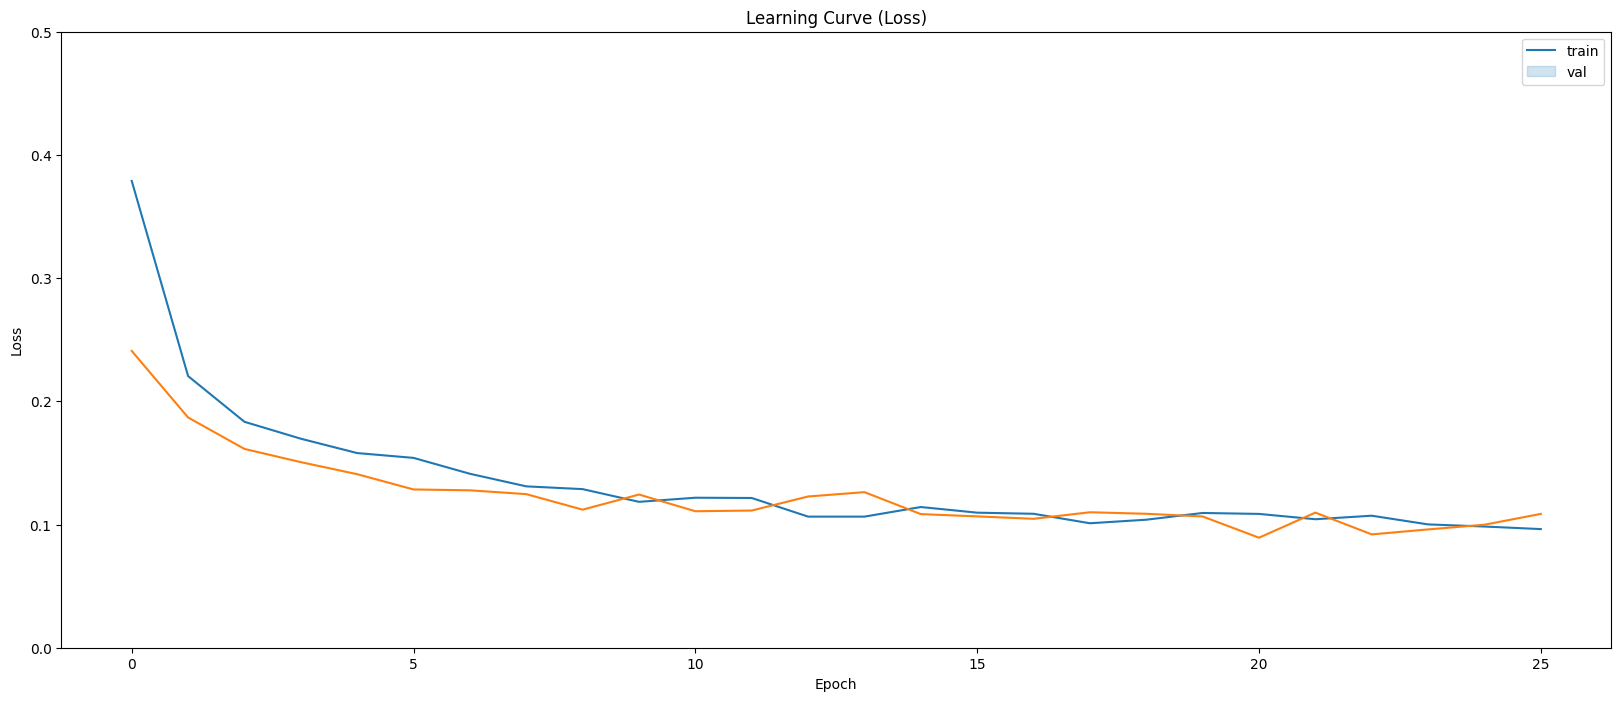

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history3.epoch, y = history3.history['loss'])
sns.lineplot(x = history3.epoch, y = history3.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

Plotting Training and Validation Accuracy for the Pretrained Model

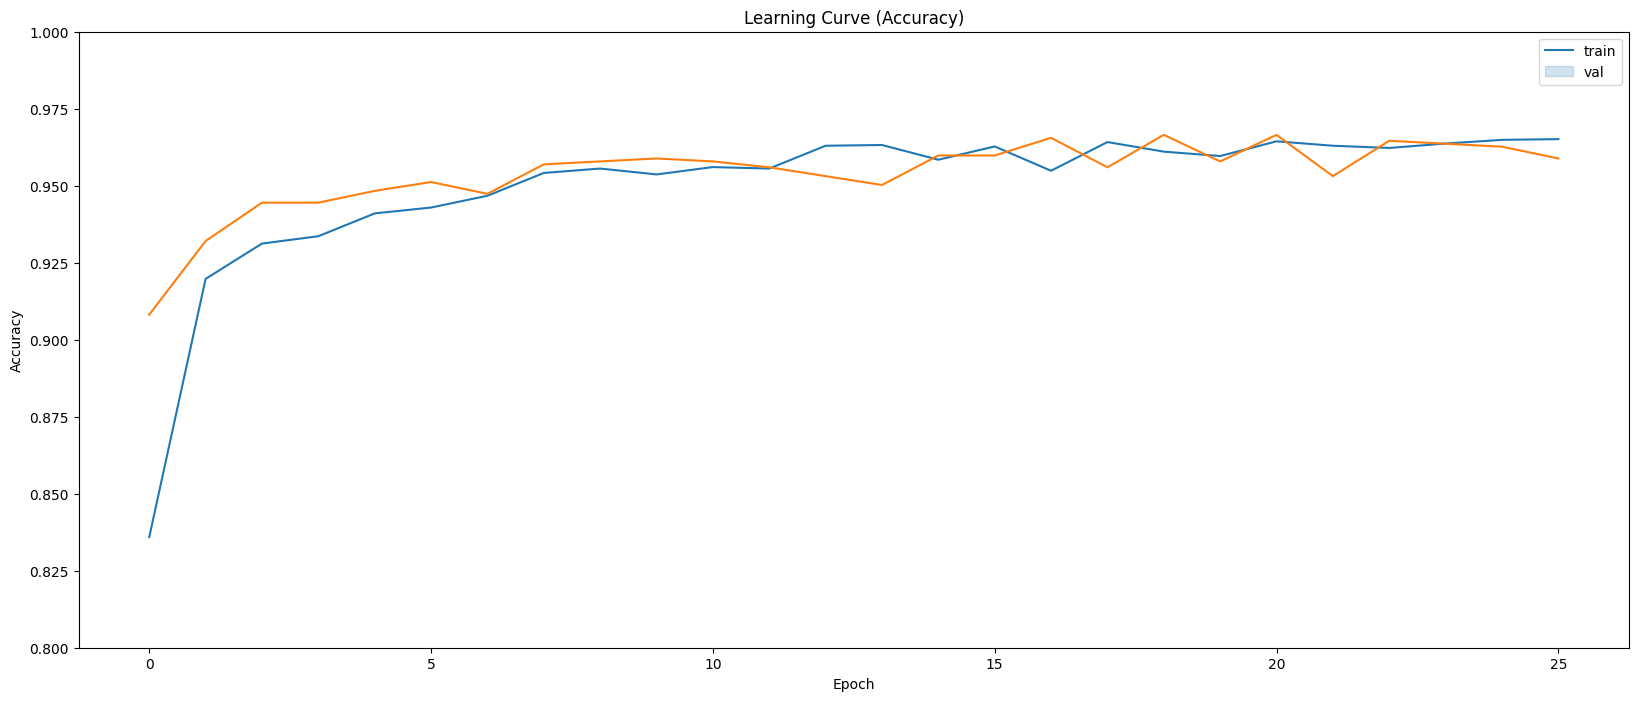

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history3.epoch, y = history3.history['binary_accuracy'])
sns.lineplot(x = history3.epoch, y = history3.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

Evaluating Pretrained Model Performance on Validation Data

In [ ]:
score = model_pretrained1.evaluate(valid_generator, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.10102806240320206
Val accuracy: 0.9655502438545227


Final Evaluation of the Pretrained Model on Test Data

In [ ]:
score = model_pretrained1.evaluate(test_generator, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20298923552036285
Test accuracy: 0.9230769276618958


Fine-Tuning the Pretrained ResNet152V2 Model

# <a id="7">Fine Tuning</a>

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [ ]:
for layer_number , layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv

Recompiling the Fine-Tuned Pretrained Model

In [ ]:
model_pretrained2 = get_pretrained()

In [ ]:
model_pretrained2.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics=['binary_accuracy'])

In [ ]:
model_pretrained2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 4,731,137 (18.05 MB)

 Non-trainable params: 53,862,912 (205.47 MB)

Fine-Tuning the CNN Model with Training and Validation

In [ ]:
history4 = model_pretrained2.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - binary_accuracy: 0.5007 - loss: 0.7055 - val_binary_accuracy: 0.7722 - val_loss: 0.5599 - learning_rate: 2.0000e-06
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 853ms/step - binary_accuracy: 0.7902 - loss: 0.5548 - val_binary_accuracy: 0.8201 - val_loss: 0.4697 - learning_rate: 2.0000e-06
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 844ms/step - binary_accuracy: 0.8217 - loss: 0.4782 - val_binary_accuracy: 0.8632 - val_loss: 0.4053 - learning_rate: 2.0000e-06
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 844ms/step - binary_accuracy: 0.8552 - loss: 0.4099 - val_binary_accuracy: 0.8880 - val_loss: 0.3483 - learning_rate: 2.0000e-06
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 846ms/step - binary_accuracy: 0.8713 - loss: 0.3672 - val_binary_accuracy: 0.9167 - val_loss: 0.3077 - learning_rate: 2.0000e-06
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 845ms/step - binary_accuracy: 0.9033 - loss: 0.3175 - val_binary_accuracy: 0.9110 - val_

Plotting Loss Curve During Fine-Tuning

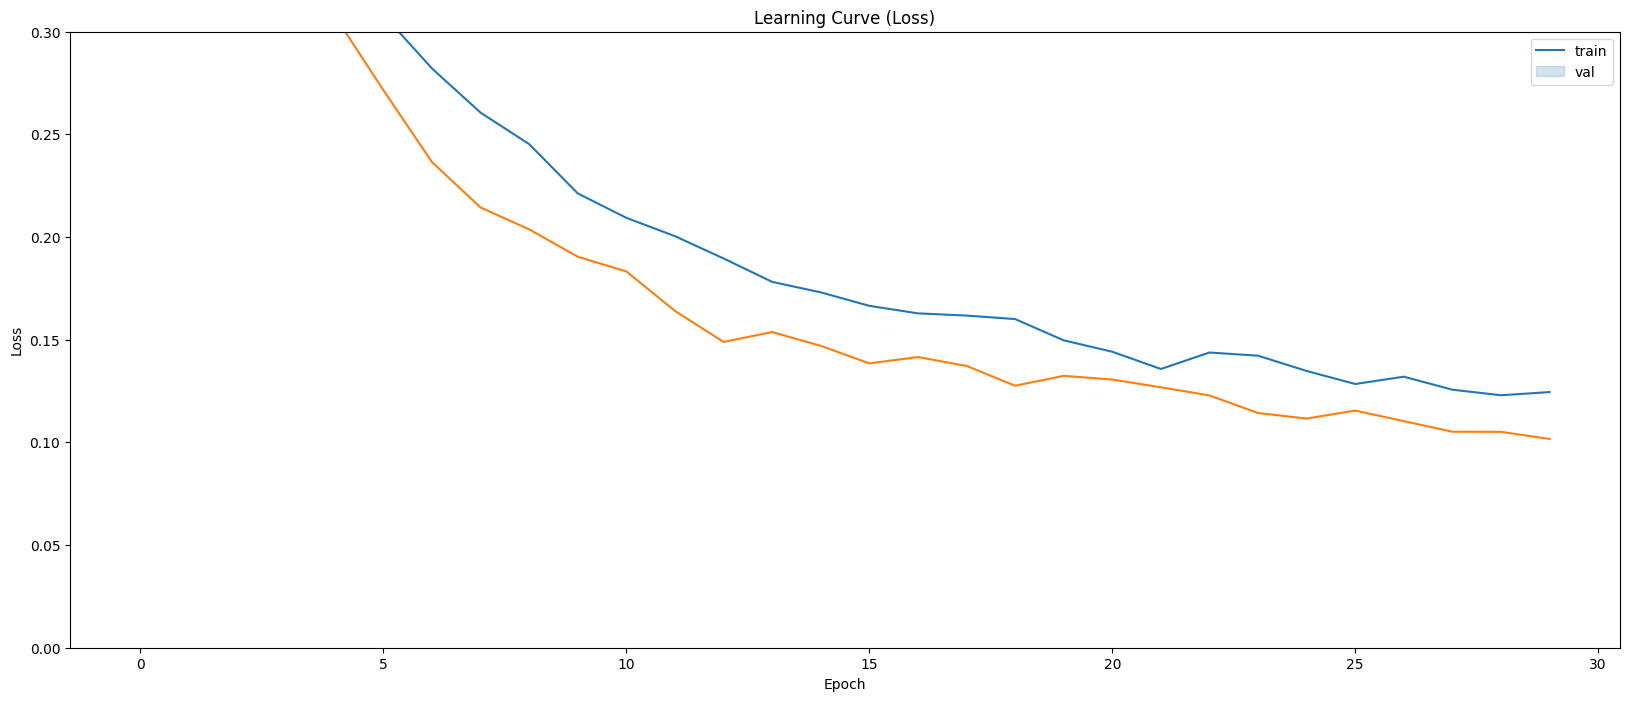

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history4.epoch, y = history4.history['loss'])
sns.lineplot(x = history4.epoch, y = history4.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

Plotting Accuracy Curve During Fine-Tuning

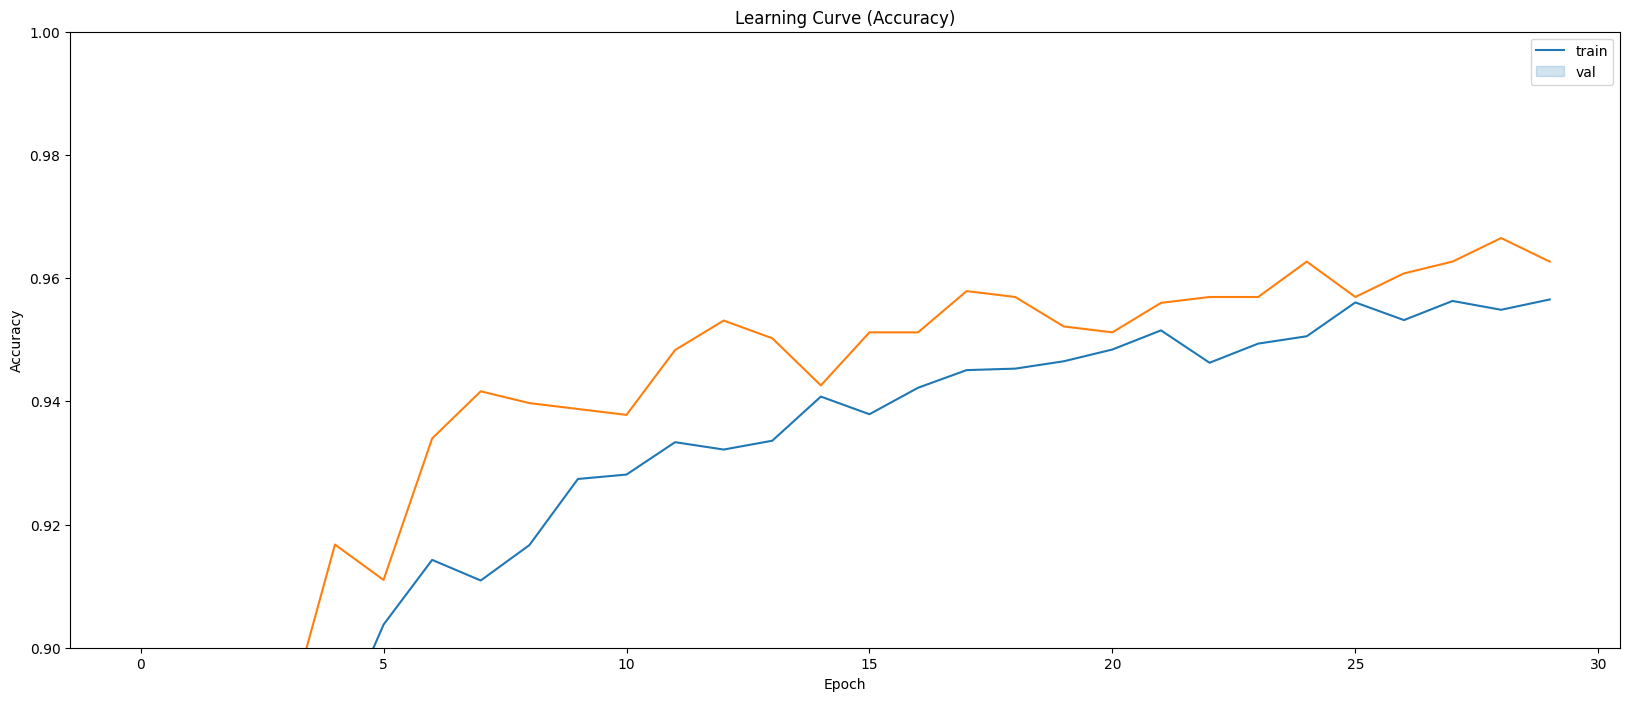

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history4.epoch, y = history4.history['binary_accuracy'])
sns.lineplot(x = history4.epoch, y = history4.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

Final Test Evaluation After Fine-Tuning

In [ ]:
score = model_pretrained2.evaluate(test_generator, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2096097618341446
Test accuracy: 0.9134615659713745


In [ ]:
results = []

test_loss1, test_acc1 = model1.evaluate(test_generator, verbose=0)

results.append({
    "Model": "Model1",
    "Val Accuracy": history1.history['val_accuracy'][-1],
    "Val Loss": history1.history['val_loss'][-1],
    "Test Accuracy": test_acc1,
    "Test Loss": test_loss1
})

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_generator, verbose=0)
results.append({
    "Model": "Model2",
    "Val Accuracy": history2.history['val_binary_accuracy'][-1],
    "Val Loss": history2.history['val_loss'][-1],
    "Test Accuracy": test_acc2,
    "Test Loss": test_loss2
})

In [ ]:
test_loss3, test_acc3 = model_pretrained1.evaluate(test_generator, verbose=0)
results.append({
    "Model": "PreTrained 1",
    "Val Accuracy": history3.history['val_binary_accuracy'][-1],
    "Val Loss": history3.history['val_loss'][-1],
    "Test Accuracy": test_acc3,
    "Test Loss": test_loss3
})

In [ ]:
test_loss4, test_acc4 = model_pretrained2.evaluate(test_generator, verbose=0)
results.append({
    "Model": "PreTrained 2",
    "Val Accuracy": history4.history['val_binary_accuracy'][-1],
    "Val Loss": history3.history['val_loss'][-1],
    "Test Accuracy": test_acc4,
    "Test Loss": test_loss4
})

Converting Model Evaluation Results into a Pandas DataFrame

In [ ]:
df_results = pd.DataFrame(results)
df_results

,Model,Val Accuracy,Val Loss,Test Accuracy,Test Loss
0,Model1,0.959809,0.114545,0.943910,0.167720
1,Model2,0.923445,0.211668,0.900641,0.299510
2,PreTrained 1,0.958852,0.108627,0.935897,0.184291
3,PreTrained 2,0.962679,0.108627,0.913462,0.209610


Save Best Model

In [ ]:
model1.save("model1.h5")

In [ ]:
model1.save("my_model.keras")